## Querys the table generated by T358345.ipynb

In [1]:
from IPython.display import display, HTML
import os
import pandas as pd
import pyarrow as pa
from pyarrow.fs import FileType
import pyarrow.parquet as pq
import subprocess

In [2]:
try:
    hdfs_cmd = os.path.join(os.environ['HADOOP_HOME'], 'bin/hdfs')
except KeyError:
    hdfs_cmd = '/usr/bin/hdfs'
os.environ['CLASSPATH'] = subprocess.check_output([hdfs_cmd, 'classpath', '--glob']).decode('utf8').strip()
fs = pa.fs.HadoopFileSystem("default")

In [3]:
hdfs_path_prefix = '/user/hive/warehouse/ebernhardson.db/t358345/year=2024/month=4'

In [4]:
df_raw = pq.read_table(
    hdfs_path_prefix,
    filesystem=fs,
    # partitioning=['year', 'month', 'day']
).to_pandas()
len(df_raw)

7019304

In [5]:
len(df_raw['day'].unique())

29

In [6]:
mem_used_gb = df_raw.memory_usage(index=True, deep=True).sum() / 2 ** 30
f'Using: ~{mem_used_gb:.1f}gb'

'Using: ~4.1gb'

In [7]:
def host_val(key):
    return df_raw['normalized_host'].apply(lambda x: x[key])

# Simplify a few queries by pre-calculating
df_raw['project_class'] = df_raw['normalized_host'].apply(lambda x: x['project_class'])
df_raw['project'] = df_raw['normalized_host'].apply(lambda x: x['project']).str.cat(df_raw['project_class'], sep='.')

In [8]:
def sorted_values(df, key, sort_by='num_pageviews', ascending=False):
    return (
        df
        .groupby(key)[[sort_by]]
        .sum()
        .sort_values(sort_by, ascending=ascending)
        .index.values
    )

In [9]:
# Only days including related articles data
df = df_raw[df_raw['day'].astype(int) >= 18]

In [10]:
df_udd = pq.read_table(
    '/wmf/data/wmf/unique_devices/per_domain/daily/year=2024/month=4',
    filesystem=fs
).to_pandas()

In [11]:
mem_used_gb = df_udd.memory_usage(index=True, deep=True).sum() / 2 ** 30
f'Using: ~{mem_used_gb:.1f}gb'

'Using: ~0.6gb'

### T358349 - Number of Searches

This metric in particular need to be split by use cases (full text search, go bar, ...) and we need to be able to filter out bot traffic. We want to be able to compare this metric with the overall number of pageviews.

Use cases:
- [x] full text search
- [x] go bar
- [x] related articles

In [12]:
def num_search_stats(df, agg_cols=None, sort_by='num_pageviews', post_filter=None):
    metric_cols = [x for x in df.columns if x.startswith('num_')]
    if agg_cols:
        grouped = df[agg_cols + metric_cols].groupby(agg_cols).sum()
    else:
        grouped = df[metric_cols].sum().to_frame().transpose()
    if post_filter:
        grouped = grouped[post_filter(grouped)]

    divisor = 'num_pageviews'
    num_days = len(df['day'].unique())
    
    result_metrics = {
        'autocomplete': grouped['num_ac_req'] / grouped[divisor],
        'go_to_page': grouped['num_go_to'] / grouped[divisor],
        'fulltext': grouped['num_serp'] / grouped[divisor],
        'related_articles': grouped['num_morelike_req'] / grouped[divisor],
        'other_api': grouped['num_other_api_fulltext_req'] / grouped[divisor],
        divisor: grouped[divisor],
        'num_daily' + divisor[3:]: (grouped[divisor] / num_days).astype(int),
    }
    
    result = pd.DataFrame(result_metrics)
    result.sort_values(sort_by, ascending=False, inplace=True)
    int_fmt = '{:,}'
    float_fmt = '{:.2%}'
    int_cols = (divisor, 'num_daily' + divisor[3:])
    return result.style.format(dict(
        **{k: int_fmt for k in int_cols},
        **{k: float_fmt for k in result_metrics.keys() if k not in int_cols}))

In [13]:
total_reqs = df[['num_ac_req', 'num_go_to', 'num_serp', 'num_morelike_req', 'num_other_api_fulltext_req']].sum().sum()
daily_search_reqs = int(total_reqs / len(df['day'].unique()))
search_req_to_pv_ratio = total_reqs / df['num_pageviews'].sum()
#daily_search_req = int(df['num_any_search_pv'].sum() / len(df['day'].unique()))
print(f'Daily search requests across all search endpoints: {daily_search_reqs:,}')
print(f'There are {int(10*search_req_to_pv_ratio):.1f} search requests for every 10 page views')

Daily search requests across all search endpoints: 200,200,643
There are 3.0 search requests for every 10 page views


In [14]:
num_search_stats(df)

In [15]:
num_search_stats(
    df,
    agg_cols=['access_method']
)

In [16]:
num_search_stats(
    df[df['project_class'] == 'wikipedia'],
    agg_cols=['access_method']
)

In [17]:
num_search_stats(
    df,
    agg_cols=['project_class'],
    sort_by='num_pageviews'
)

In [18]:
num_search_stats(
    df[df['project'].isin(sorted_values(df, 'project')[:20])],
    agg_cols=['project'],
    sort_by='num_pageviews',
)

In [19]:
for access_method in df['access_method'].unique():
    display(num_search_stats(
        df[
            (df['project_class'] == 'wikipedia')
            & (df['access_method'] == access_method)
        ],
        agg_cols=['access_method', 'os_family'],
        post_filter=lambda x: x['num_pageviews'] > 1000000,
        sort_by='num_pageviews',
    ))

## T358351 - Read traffic generated by Search

Initially, the output should specify the ratios as:

1. Number of user pageviews associated with Wikimedia search divided by each of the following
2. Number of user pageviews associated with external search (by way of the referer_data field of webrequest; bonus points for breakout by referer_name when it is external search-based) divided by each of the following
3. Number of Related Articles fetches via the edge (mobile web only) divided by the following (n.b. this will serve as a good-enough proxy for impressions for now)

Preferred:

- [x] internally referred daily pageviews
- [ ] inferred monthly users, based on pageview_actor hashing approach
- [x] inferred daily users, based on pageview_actor hashing approach
- [ ] estimated daily unique devices, based on unique_devices_per_domain_daily
- [x] total daily user pageviews

And if queries will run successfully:

- [x] internally referred monthly pagviews
- [ ] estimated monthly unique devices, based on unique_devices_per_domain_monthly
- [x] total monthly user pageviews

In [20]:
def read_traffic_stats(
    df,
    agg_cols=None,
    divisor='num_pageviews',
    sort_by=None,
    post_filter=None,
):
    metric_cols = [x for x in df.columns if x.startswith('num_')]
    if agg_cols:
        grouped = df[agg_cols + metric_cols].groupby(agg_cols).sum()
    else:
        grouped = df[metric_cols].sum().to_frame().transpose()
    if post_filter:
        grouped = grouped[post_filter(grouped)]

    # Total daily user pageviews, internally referred daily pageviews
    if divisor in ('num_pageviews', 'num_internal_pv'):
        key_fmt = '{k}'
        metric_fmt = 'num_{k}'
    # inferred daily actors, inferred daily actors w/ internally referred pageviews
    elif divisor in ('num_actors_w_pageviews', 'num_actors_w_internal_pv'):
        key_fmt = '{k}_actors'
        metric_fmt = 'num_actors_w_{k}'
    else:
        raise ValueError(f'Unknown divisor: {divisor}')
    
    int_cols = {
        divisor: grouped[divisor],
        'num_daily_' + divisor[4:]: (grouped[divisor] / len(df['day'].unique())).astype(int),
    }

    metrics = (
        # pageviews associated with wikimedia fulltext or autocomplete
        'search_pv',
        # pageviews associated with external search
        'external_search_pv',
        # pageviews associated with related articles 
        'related_articles_pv'
    )

    float_cols = {
        key_fmt.format(k=k): grouped[metric_fmt.format(k=k)] / grouped[divisor]
        for k in metrics
    }

    result = pd.DataFrame(dict(**float_cols, **int_cols), index=grouped.index)

    if sort_by is None:
        sort_by = divisor
    result.sort_values(sort_by, ascending=False, inplace=True)

    return result.style.format(dict(
        **{k: '{:,}'for k in int_cols.keys()},
        **{k: '{:.2%}' for k in float_cols.keys()},
    ))
    
read_traffic_stats.divisors = [
    'num_pageviews',
    'num_internal_pv',
    'num_actors_w_pageviews',
    'num_actors_w_internal_pv'
]

In [21]:
daily_search_pv = int(df['num_any_search_pv'].sum() / len(df['day'].unique()))
daily_search_actors = int(df['num_actors_w_any_search_pv'].sum() / len(df['day'].unique()))
print(f'Daily pageviews across all search endpoints: {daily_search_pv:,}')
print(f'Daily pageview actors across all search endpoints: {daily_search_actors:,}')

Daily pageviews across all search endpoints: 12,363,732
Daily pageview actors across all search endpoints: 5,446,388


In [22]:
for divisor in read_traffic_stats.divisors:
    display(read_traffic_stats(df, divisor=divisor))

In [23]:
for divisor in read_traffic_stats.divisors:
    display(read_traffic_stats(
        df,
        agg_cols=['access_method'],
        divisor=divisor,
    ))

In [24]:
for access_method in df['access_method'].unique():
    display(read_traffic_stats(
        df[df['access_method'] == access_method],
        divisor='num_pageviews',
        agg_cols=['access_method', 'os_family'],
        post_filter=lambda x: x['num_pageviews'] > 1_000_000
    ))

In [25]:
for divisor in ['num_pageviews', 'num_actors_w_internal_pv']:
    for os_family in sorted_values(df, 'os_family')[:5]:
        display(read_traffic_stats(
            df[df['os_family'] == os_family],
            divisor=divisor,
            agg_cols=['os_family', 'access_method'],
        ))

In [26]:
for divisor in ['num_pageviews', 'num_actors_w_pageviews']:
    display(read_traffic_stats(
        df[df['country'].isin(sorted_values(df, 'country')[:20])],
        agg_cols=['country'],
        divisor=divisor,
    ))

In [27]:
for country in sorted_values(df, 'country')[:5]:
    display(read_traffic_stats(
        df[df['country'] == country],
        agg_cols=['country', 'access_method'],
        divisor='num_pageviews',
    ))

In [28]:
for access_method in df['access_method'].unique():
    display(read_traffic_stats(
        df[
            df['country'].isin(sorted_values(df, 'country')[:20])
            & (df['access_method'] == access_method)
        ],
        agg_cols=['access_method', 'country'],
        divisor='num_actors_w_pageviews',
    ))

## Compare actor counts against official unique device counts

Unfortunately they aren't strongly correlated, but hopefully they are still providing a reasonable proxy

In [29]:
official_daily_uniques = (
    df_udd[df_udd['domain'].isin(['en.wikipedia.org', 'en.m.wikipedia.org'])]
    .groupby('day')['uniques_estimate'].sum()
)
actor_daily_uniques = (
    df_raw[df_raw['project'] == 'en.wikipedia']
    .groupby('day')['num_actors_w_pageviews'].sum()
)
df_actor_vs_unique = pd.concat([official_daily_uniques, actor_daily_uniques], axis=1)
df_actor_vs_unique.index = df_actor_vs_unique.index.astype(int)
df_actor_vs_unique.sort_index(inplace=True)

In [30]:
df_actor_vs_unique['uniques_estimate'].corr(df_actor_vs_unique['num_actors_w_pageviews'])

0.5319445980663574

<AxesSubplot: xlabel='day'>

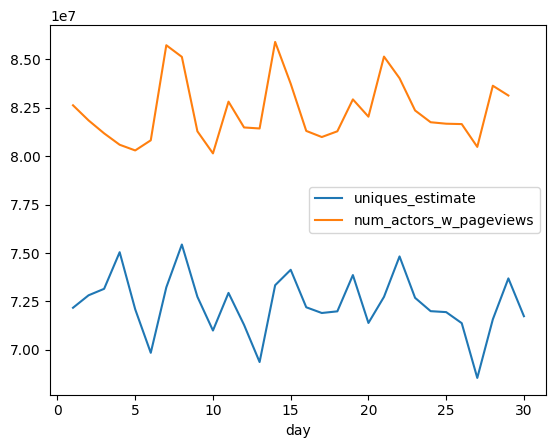

In [31]:
df_actor_vs_unique.plot()

In [32]:
df_actor_vs_unique

uniques_estimate  num_actors_w_pageviews
day                                          
1            72174606              82623459.0
2            72817677              81843928.0
3            73151609              81175722.0
4            75041648              80587644.0
5            72094157              80293676.0
6            69849221              80816977.0
7            73227446              85723713.0
8            75437610              85123073.0
9            72741176              81281141.0
10           70999647              80141806.0
11           72941409              82811776.0
12           71290932              81480160.0
13           69373646              81427307.0
14           73337797              85894456.0
15           74133905              83737646.0
16           72199860              81301466.0
17           71903975              80985898.0
18           71989580              81281652.0
19           73861608              82928310.0
20           71389348              82035831.0
21           72737059              85137186.0
22           74823659              84021328.0
23           72686582              82356876.0
24           71999010              81749450.0
25           71949338              81673292.0
26           71379716              81653648.0
27           68553308              80476678.0
28           71575910              83632655.0
29           73689967              83129297.0
30           71738347                     NaN